In [187]:
import tensorflow as tf
import os
import logging
import shutil
import json
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

current_directory = os.getcwd()
path_components = current_directory.split(os.path.sep)
new_directory = os.path.sep.join(path_components[:-1])

sys.path.append(new_directory)

from DCM.PDE_Model import Poisson
from DCM.PDE_Model import Helmholtz
from DCM.PDE_Model import PBE_Interface

from DCM.Mesh import Mesh
from NN.NeuralNet import PINN_NeuralNet

from NN.PINN import PINN
from NN.XPINN import XPINN

from Postprocessing import View_results
from Postprocessing import View_results_X

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

results_dir = os.path.sep.join(path_components[:-2])
#main_path = os.path.join(results_dir,'results','TEST_09_13_tulio','S_H2_N2_B0_W0')
main_path = os.path.join(results_dir,'utils3d','results','data')                        
                         
print(main_path)


c:\Users\achom\Desktop\Main\Code\Scientific-Computing\Physics-Neural-Networks\PINN\utils3d\results\data


In [188]:

class Simulation():
    
    def __init__(self, PDE):
          self.problem = None
          self.mesh = None
          self.weights = None
          self.lr = None
          self.hyperparameters = None
          self.PDE_Interface = PDE
          self.precondition=False
          self.names = []

    def setup_algorithm(self):
        
        PDE_in = self.PDE_in
        domain_in = PDE_in.set_domain(self.domain_in)

        PDE_out = self.PDE_out
        domain_out = PDE_out.set_domain(self.domain_out)
   
        mesh_in = Mesh(domain_in, mesh_N=self.mesh_in, precondition=self.precondition)
        mesh_in.create_mesh(self.extra_meshes_in, self.ins_domain_in)

        mesh_out = Mesh(domain_out, mesh_N=self.mesh_out, precondition=self.precondition)
        mesh_out.create_mesh(self.extra_meshes_out, self.ins_domain_out)

        PDE = self.PDE_Interface()
        PDE.adapt_PDEs([PDE_in,PDE_out],[PDE_in.epsilon,PDE_out.epsilon])
        PDE.epsilon_G = PDE_in.epsilon_G
        PDE.q = PDE_in.q
        PDE.problem = self.problem

        self.XPINN_solver = XPINN(PINN)
        self.XPINN_solver.adapt_PDEs(PDE)
        self.XPINN_solver.adapt_meshes([mesh_in,mesh_out],[self.weights,self.weights])
        
        self.XPINN_solver.load_NeuralNets(self.folder_path,self.names,[self.lr,self.lr])
        
        



In [189]:

Sim = Simulation(PBE_Interface)

# PDE
q_list = [(1,[0,0,0])]

inputs = {'Problem': 'Main_X',
            'rmin': 0,
            'rI': 1,
            'rB': 10,
            'epsilon_1':1,
            'epsilon_2':80,
            'kappa': 0.125,
            }

Sim.problem = inputs
Sim.q = q_list

rI = inputs['rI']
rB = inputs['rB']

Sim.domain_in = ([-rI,rI],[-rI,rI],[-rI,rI])
Sim.PDE_in = Poisson()
Sim.PDE_in.sigma = 0.04
Sim.PDE_in.epsilon = inputs['epsilon_1']
Sim.PDE_in.epsilon_G = inputs['epsilon_1']
Sim.PDE_in.q = q_list
Sim.PDE_in.problem = inputs

inner_interface = {'type':'I', 'value':None, 'fun':None, 'r':rI, 'N': 40}
inner_data = {'type':'K', 'value':None, 'fun':lambda x,y,z: Sim.PDE_in.analytic(x,y,z), 'r':'Random', 'N': 20}
Sim.extra_meshes_in = {'1':inner_interface, '2': inner_data}
Sim.ins_domain_in = {'rmax': rI}


Sim.domain_out = ([-rB,rB],[-rB,rB],[-rB,rB])
Sim.PDE_out = Helmholtz()
Sim.PDE_out.epsilon = inputs['epsilon_2']
Sim.PDE_out.epsilon_G = inputs['epsilon_1']
Sim.PDE_out.kappa = inputs['kappa']
Sim.PDE_out.q = q_list 
Sim.PDE_out.problem = inputs

u_an = Sim.PDE_out.border_value(rB,0,0,rI)
outer_interface = {'type':'I', 'value':None, 'fun':None, 'r':rI, 'N':50}
outer_dirichlet = {'type':'D', 'value':u_an, 'fun':None, 'r':rB, 'N': 50}
outer_data = {'type':'K', 'value':None, 'fun':lambda x,y,z: Sim.PDE_out.analytic(x,y,z), 'r':'Random', 'N': 20}
Sim.extra_meshes_out = {'1':outer_interface,'2':outer_dirichlet, '3': outer_data}
Sim.ins_domain_out = {'rmax': rB,'rmin':rI}

# Mesh
Sim.mesh_in = {'N_r': 40,
                'N_r_P': 40}
Sim.mesh_out = {'N_r': 40,
                'N_r_P': 40}

# Neural Network
Sim.weights = {
    'w_r': 1,
    'w_d': 1,
    'w_n': 1,
    'w_i': 1,
    'w_k': 1
}

Sim.lr = ([3000,6000],[1e-2,5e-3,5e-4])

Nplot = 2000
Sim.folder_path = os.path.join(main_path, f'iter_{str(Nplot)}')

Sim.names = ['model_1','model_2']

Sim.setup_algorithm()




In [190]:
Sim.XPINN_solver.N_iters = Sim.XPINN_solver.iter
Post = View_results_X(Sim.XPINN_solver, View_results, save=True, directory=Sim.folder_path, data=False)


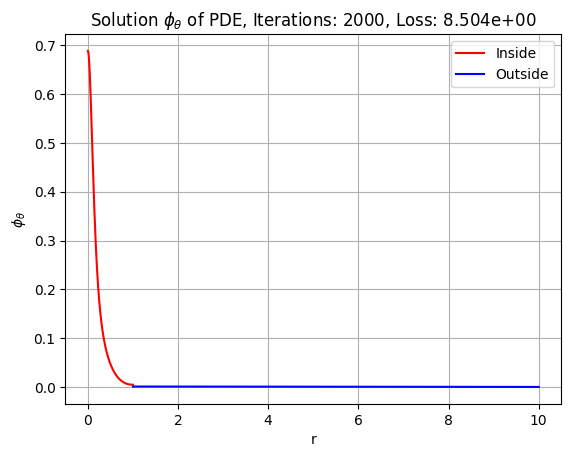

In [191]:
Post.plot_u_plane(theta=np.pi, phi=0)

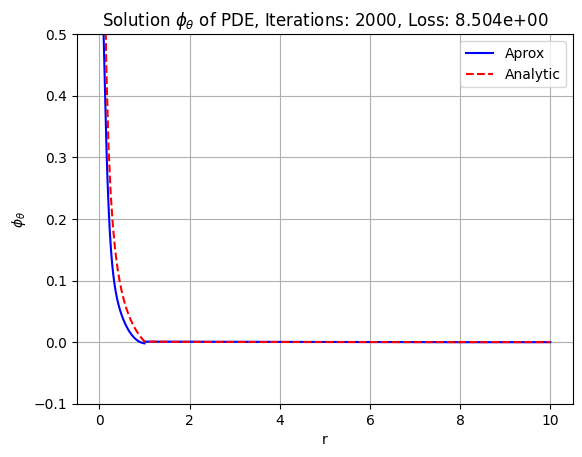

In [192]:
Post.plot_aprox_analytic(theta=np.pi/6, phi=np.pi/6, lims=[-0.1,0.5])

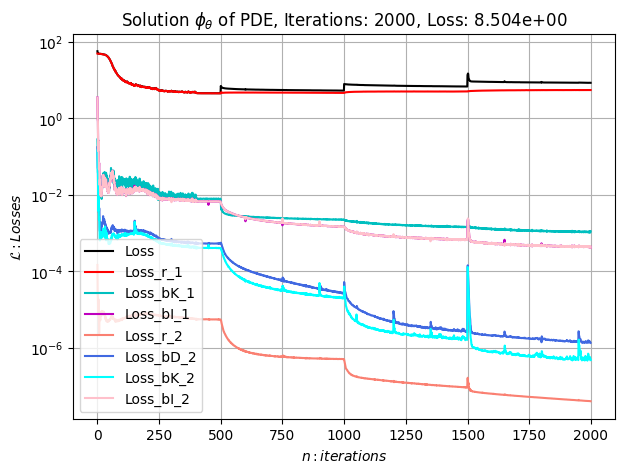

In [193]:
Post.plot_loss_history()

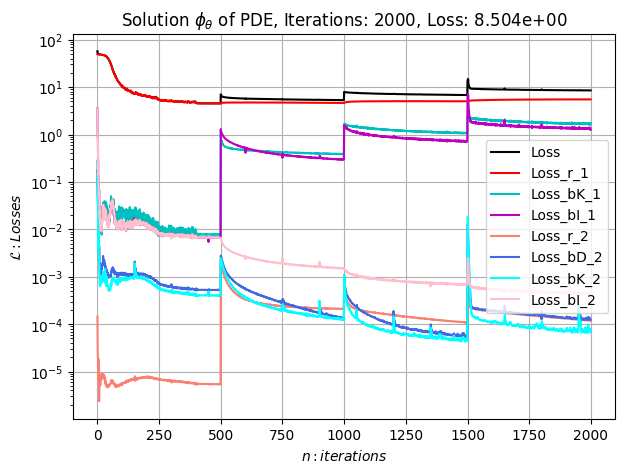

In [194]:
Post.plot_loss_history(plot_w=True)

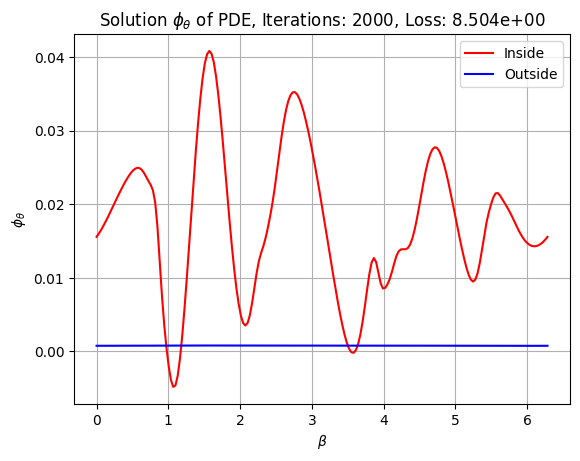

In [195]:
Post.plot_interface()

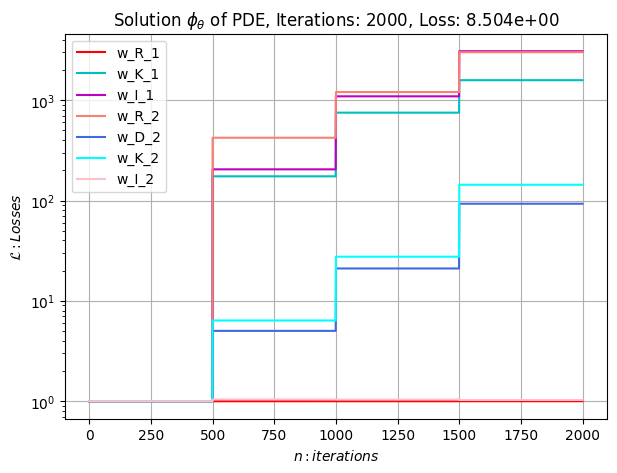

In [196]:
Post.plot_weights_history()

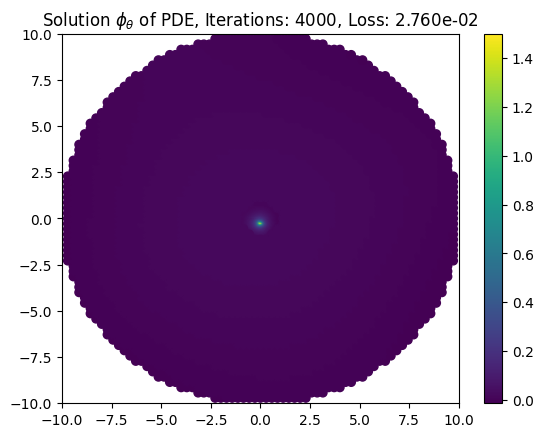

In [71]:
Post.plot_u_domain_contour(N=70)